In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import re
import spacy
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer



In [42]:
import en_core_web_sm
spacy_nlp   = en_core_web_sm.load() 
#if you would like to replicate this on your own machine, you will have to install spaCy, then go into terminal and type: python -m spacy download en_core_web_sm 
# in order to run this particular cell


In [74]:
musktweets = pd.read_csv('cleandata.csv')
print(len(musktweets))
musktweets.head()



2668


,Tweets,Retweets,Likes,Date,Cleaned_Tweets
0,@PeterSchiff 🤣 thanks,209,7021,2022-10-27 16:17:39,thanks
1,@ZubyMusic Absolutely,755,26737,2022-10-27 13:19:25,Absolutely
2,Dear Twitter Advertisers https://t.co/GMwHmInPAS,55927,356623,2022-10-27 13:08:00,Dear Twitter Advertisers
3,Meeting a lot of cool people at Twitter today!,9366,195546,2022-10-26 21:39:32,Meeting a lot of cool people at Twitter today!
4,Entering Twitter HQ – let that sink in! https:...,145520,1043592,2022-10-26 18:45:58,Entering Twitter HQ – let that sink in!


We begin with word tokenization. We will extract words from the cleaned_tweets (thank you Marta!) after removing stop words (repeptive, meaningless words like "I", "we", "is"... etc) except domain specific ones (we care about these ones). Then, we tokenize them to gather the frequency of each respective word. The intended product is to create a wordcloud that displays the most talked about subjects/words used.

In [44]:
def clean_tweets(tweet):
    word_tokens = spacy_nlp(tweet)
    tokens      = []
    
    for w in word_tokens:
        if not w.is_stop:
            s   = w.text.lower()
            tokens += s.split()
    text = " ".join(tokens)

    word_tokens    = spacy_nlp(text)
    filtered_tweet = []
    for w in word_tokens:
        if not w.is_stop:
            if w.lemma_ != "-PRON-":
                s = w.lemma_.lower()
            else:
                s = w.lower_
            s = s.strip('-')
            if len(s) <= 1:
                continue
            if re.match(r'^[a-zA-Z_\.]+$', s):
                filtered_tweet.append(s)
    
    return filtered_tweet

In [91]:
for i in range(5):
    print(clean_tweets(musktweets['Cleaned_Tweets'][i]))


['thank']
['absolutely']
['dear', 'twitter', 'advertiser']
['meet', 'lot', 'cool', 'people', 'twitter', 'today']
['enter', 'twitter', 'hq', 'let', 'sink']


In [46]:
tweets = list(musktweets["Cleaned_Tweets"].values)
tweets[0:5]

[' thanks',
 'Absolutely',
 'Dear Twitter Advertisers',
 'Meeting a lot of cool people at Twitter today!',
 'Entering Twitter HQ – let that sink in!']

In [47]:
processed = []

for t in tweets: #most time intensive process on lower-spec machines. It took me ~1 minute to run this cell, so don't be worried!
    try: 
        processed.append(clean_tweets(t))
    except: pass

dictionary = gensim.corpora.Dictionary(processed)
dictionarywords = dict(dictionary)
bagowords = [dictionary.doc2bow(doc) for doc in processed]

In [48]:
flatowords = [i for tweet in bagowords for i in tweet]
flatowords = [tweet[0] for tweet in flatowords]
flatowords = [dictionarywords[word] for word in flatowords]

In [49]:
freq = {}
for word in flatowords:
    if (word in freq):
        freq[word] += 1
    else:
        freq[word] = 1
del freq['amp'] #amp is the shorthand for ampersand (&) symbol. This is for some reason not processed by spaCy.

In [50]:
len(flatowords)

14981

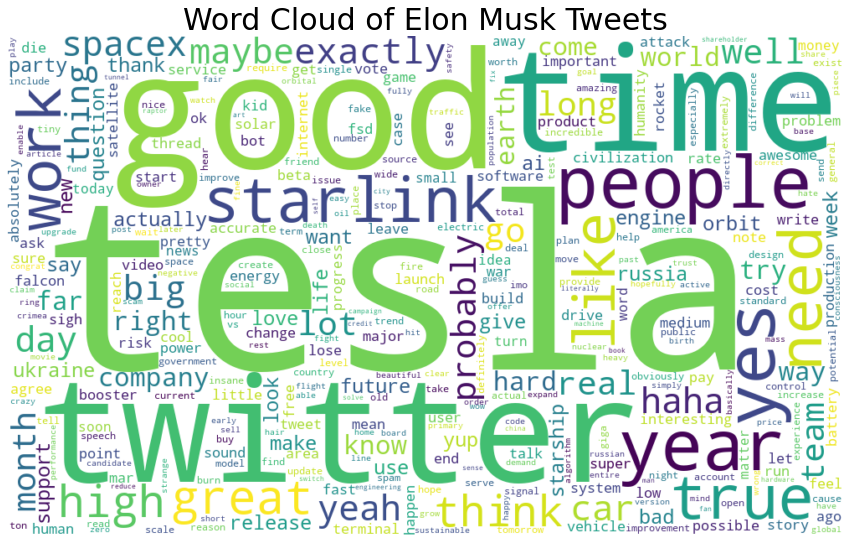

In [51]:
wc = WordCloud(background_color="white", 
               max_words=350, 
               width=1000, 
               height=600, 
               random_state=1).generate_from_frequencies(freq)
plt.figure(figsize = (15,15))
plt.imshow(wc, interpolation="bilinear")
plt.title("Word Cloud of Elon Musk Tweets", fontsize = 30)
plt.axis("off")
plt.savefig("muskwordcloud.png", dpi = 800)

Figure 1: Wordcloud of Elon Musk's most commonly used words in tweets. Words like "Tesla", "Twitter", and "Good" are the most commonly used.


In order to visualize the data numerically, I have also created a bar chart of the top 20 most commonly used words.

In [52]:
wordDF = pd.DataFrame.from_dict(freq, orient = "index")

In [53]:
wordDF = wordDF.sort_values(by = 0, ascending = False)
top20 = wordDF.iloc[:20]

In [204]:
top20

,0
tesla,142
good,118
twitter,92
time,91
people,88
year,86
yes,82
starlink,81
true,76
work,74


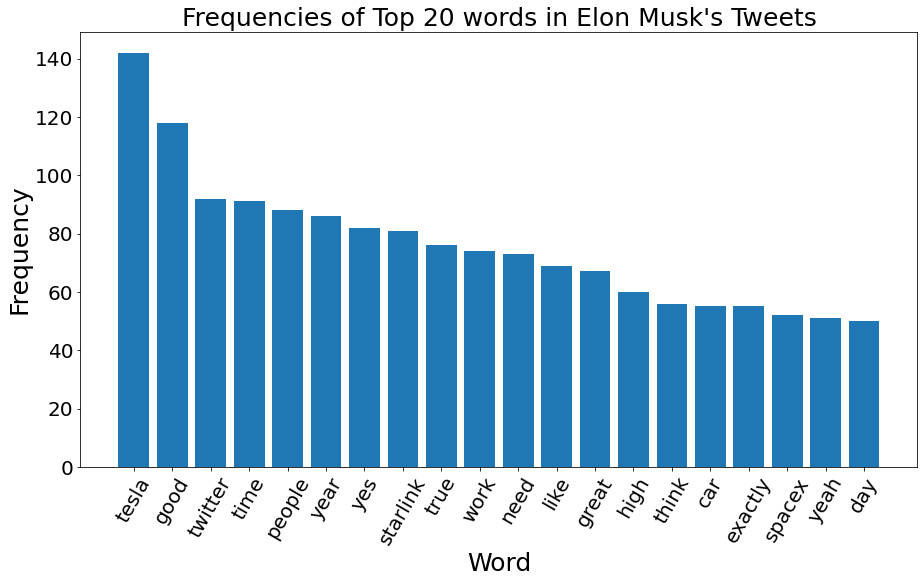

In [54]:
plt.figure(figsize = (15,8))
plt.bar(range(len(top20)), list(top20[0]), tick_label = list(top20.index))
plt.title("Frequencies of Top 20 words in Elon Musk's Tweets", fontsize = 25)
plt.xlabel("Word", fontsize = 25)
plt.ylabel("Frequency", fontsize = 25)
plt.xticks(rotation = 60, fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig("wordbarchart.png",dpi = 400)

Figure: Bar chart of the top 20 most used words in Elon Musk's tweets. Just like the word cloud, "Tesla", "Good", and "Twitter" are the most common, with the former two dominating the space. The rest of the words are more or less uniform in their distribution.

Now we go on to sentiment analysis, with the vader Sentiment analysis library. Sentiment analysis looks at the words in a sentence and assigns a score for positive, negative, and neutral polarities, based on empirically created scores. For example, a word like "happy" would be calculated as having a positive score, while a word like "angry" would be defined as having a negative score. The final compound score is a normalization of the three polarity scores - thus, a negative compound score means the tweet was overall negative in sentiment, positive meaning the tweet was overall positive, and 0 being classified as "neutral". We are interested in examining the progression of Elon Musk's tweets to see if his tweets have gotten more positive, negative, or neutral as the year went on.

In [75]:
def sentiment_analyzer(tweetlist):
    
    analyser  = SentimentIntensityAnalyzer()
    pos, neg, neut  = [], [], []
    tweetlist = list(tweetlist['Cleaned_Tweets'])
    for tweet in tweetlist:
        score = analyser.polarity_scores(tweet)
        
        if score['compound']   >0: # positive comments
            pos.append(i)
        elif score['compound'] <0: # negative comments
            neg.append(i)
        else:
            neut.append(i)
    return (pos, neut, neg)

In [76]:
pos, neut, neg = sentiment_analyzer(musktweets)
print(len(pos), len(neg), len(neut))

1201 465 1002


In [77]:
from datetime import datetime

musktweets['Date']=musktweets['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
musktweets['Date'] = musktweets['Date'].apply(lambda x: x.date())

In [78]:
from datetime import date

jantweets = musktweets[musktweets.Date < date(2022,2,1)]
febtweets = musktweets[musktweets.Date >= date(2022,2,1)][musktweets.Date < date(2022,3,1)]
marchtweets = musktweets[musktweets.Date >= date(2022,3,1)][musktweets.Date < date(2022,4,1)]
apriltweets = musktweets[musktweets.Date >= date(2022,4,1)][musktweets.Date < date(2022,5,1)]
maytweets = musktweets[musktweets.Date >= date(2022,5,1)][musktweets.Date < date(2022,6,1)]
junetweets = musktweets[musktweets.Date >= date(2022,6,1)][musktweets.Date < date(2022,7,1)]
julytweets = musktweets[musktweets.Date >= date(2022,7,1)][musktweets.Date < date(2022,8,1)]
augusttweets = musktweets[musktweets.Date >= date(2022,8,1)][musktweets.Date < date(2022,9,1)]
septembertweets = musktweets[musktweets.Date >= date(2022,9,1)][musktweets.Date < date(2022,10,1)]
octobertweets = musktweets[musktweets.Date >= date(2022,10,1)][musktweets.Date < date(2022,11,1)]

months = [jantweets,febtweets,marchtweets,apriltweets,maytweets,junetweets,julytweets,augusttweets,septembertweets,octobertweets]





C:\Users\RICHAR~1\AppData\Local\Temp/ipykernel_468/1036190498.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  febtweets = musktweets[musktweets.Date >= date(2022,2,1)][musktweets.Date < date(2022,3,1)]
C:\Users\RICHAR~1\AppData\Local\Temp/ipykernel_468/1036190498.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  marchtweets = musktweets[musktweets.Date >= date(2022,3,1)][musktweets.Date < date(2022,4,1)]
C:\Users\RICHAR~1\AppData\Local\Temp/ipykernel_468/1036190498.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  apriltweets = musktweets[musktweets.Date >= date(2022,4,1)][musktweets.Date < date(2022,5,1)]
C:\Users\RICHAR~1\AppData\Local\Temp/ipykernel_468/1036190498.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  maytweets = musktweets[musktweets.Date >= date(2022,5,1)][musktweets.Date < date(2022,6,1)]
C:\Users\RICHAR~1\AppData\Local\Temp/ipykern

In [79]:
countlist = []
for month in months:
    pos, neut, neg = sentiment_analyzer(month)
    countlist.append((len(pos),len(neut),len(neg)))

countmat = np.array(countlist)
poscount = countmat[:,0]
neutcount = countmat[:,1]
negcount = countmat[:,2]



In [80]:
tweetsum = [i.sum() for i in countmat]

In [210]:
tweetsum
posprop = poscount/tweetsum *100
neutprop = neutcount/tweetsum *100
negprop = negcount/tweetsum *100


C:\Users\RICHAR~1\AppData\Local\Temp/ipykernel_468/2611963713.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("sentimentbarchartprop", dpi = 400, bbox_inches = "tight")


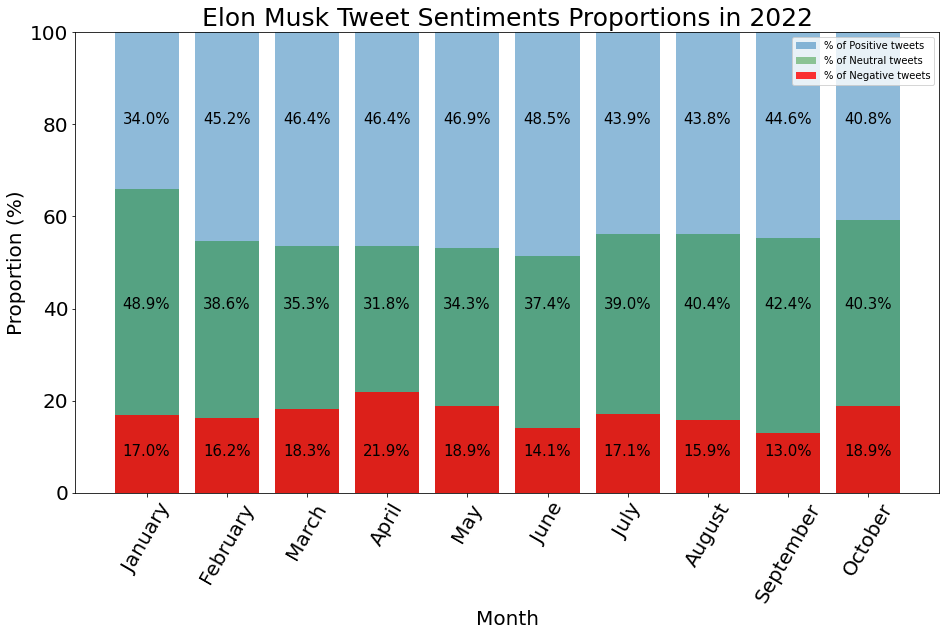

In [243]:
fig = plt.figure(figsize = (15,8))
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
monthIDX = [0,1,2,3,4,5,6,7,8,9]
#plt.plot(posprop, label = "Positive Tweets", c = 'b')
#plt.plot(neutprop+negprop, label = "Neutral Tweets", c = 'g')
#plt.plot(negprop, label = "Negative Tweets", c = 'r')
plt.bar([0,1,2,3,4,5,6,7,8,9],[100,100,100,100,100,100,100,100,100,100], alpha = 0.5, label = "% of Positive tweets")
plt.bar(monthIDX, neutprop+negprop, alpha = 0.4, color = 'g', label = "% of Neutral tweets")
plt.bar(monthIDX, negprop, alpha = 0.8, color = 'r', label = "% of Negative tweets")
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax.set_xticklabels(months)
plt.legend()
plt.title('Elon Musk Tweet Sentiments Proportions in 2022', fontsize = 25)
plt.ylim([0,100])
plt.xlabel('Month', fontsize = 20)
plt.ylabel('Proportion (%)',fontsize = 20)
plt.xticks(fontsize = 20, rotation = 60)
plt.yticks(fontsize = 20)
for i in monthIDX:
    plt.text(i-0.3, 8, str(np.round(negprop[i],1))+"%", fontsize = 15)
for i in monthIDX:
    plt.text(i-0.3, 40, str(np.round(neutprop[i],1))+"%", fontsize = 15)    
for i in monthIDX:
    plt.text(i-0.3, 80, str(np.round(posprop[i],1))+"%", fontsize = 15)
plt.savefig("sentimentbarchartprop", dpi = 400, bbox_inches = "tight")

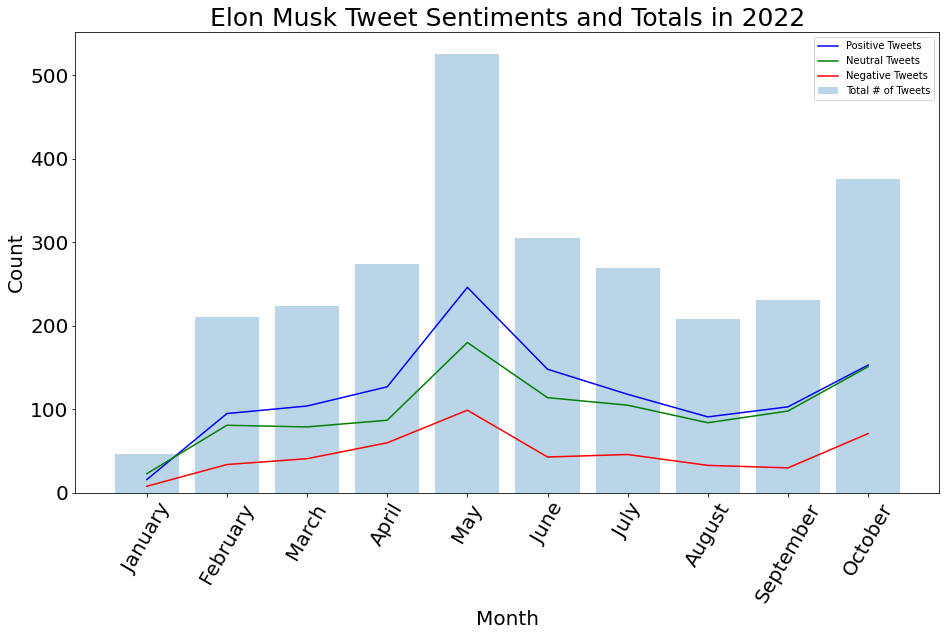

In [239]:
fig = plt.figure(figsize = (15,8))
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.plot(poscount, label = "Positive Tweets", c = 'b')
plt.plot(neutcount, label = "Neutral Tweets", c = 'g')
plt.plot(negcount, label = "Negative Tweets", c = 'r')
plt.bar([0,1,2,3,4,5,6,7,8,9],tweetsum, alpha = 0.3, label = "Total # of Tweets")
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax.set_xticklabels(months)
plt.legend()
plt.title('Elon Musk Tweet Sentiments and Totals in 2022', fontsize = 25)
plt.xlabel('Month', fontsize = 20)
plt.ylabel('Count',fontsize = 20)
plt.xticks(fontsize = 20, rotation = 60)
plt.yticks(fontsize = 20)
plt.savefig("sentimentbarchart", dpi = 400, bbox_inches = "tight")

Figure: Line and bar chart representing the time series of Elon Musk's tweet sentiments in the year 2022. We can see that most of his tweets are positive in sentiment, and all three types of tweets follow roughly the same pattern. However, past May of 2022 the rate of change for his number of positive tweets begins to decrease, becoming closely in tandem with the number of neutral tweets, which implies that past May of 2022 he begins to tweet out less and less positive tweets. 

(realistically, this section should be before sentiment analysis but I did the easy stuff first before moving on to this)


We are interested in what topics/words are most related in Elon Musk's tweets. In order to do this, we create a network graph to visualize and analyze the connections between words used in Musk's tweets. 

We will calculate all the two-word combinations of Musk's tweets and generate their respective frequencies. Another popular method is to calculate all two-word n-grams (bigrams), which are only sequential words. We will prefer the combination method as it will incorporate the bigrams as a combination (due to how combinations are calculated), as well as its ability to capture more of the overall subjects of the tweets in case longer tweets discuss more than one topic. This may introduce soem false positives into the final calculation, but we can circumvent this by setting a threshold on the required number of hits.


In [82]:
processed
import itertools
list(itertools.combinations([1, 2, 3],2))

[(1, 2), (1, 3), (2, 3)]

In [83]:
combinations = []
for tweet in processed:
    combinations.append(list(itertools.combinations(tweet,2)))
combinations = [combination for combination in combinations if len(combination)>0]
combinations = [item for combination in combinations for item in combination]
combinations = [combination for combination in combinations if "amp" not in combination] #removing ampsersand again
combinations = [combination for combination in combinations if combination[0] != combination[1]]
combfreq = {}
for tup in combinations:
    if (tup in combfreq):
        combfreq[tup] += 1
    else:
        combfreq[tup] = 1


In [84]:
combDF = pd.DataFrame.from_dict(combfreq, orient = "index")
combDF = combDF.sort_values(by = 0, ascending = False)
combDF = (combDF[combDF[0]>1])
combDF = combDF.reset_index()
combDF = combDF.rename(columns = {'index': "comb", 0: 'weight'})
combDF


,comb,weight
0,"(russia, ukraine)",17
1,"(russia, crimea)",16
2,"(tesla, ai)",16
3,"(tesla, company)",14
4,"(free, speech)",14
...,...,...
7699,"(lift, people)",2
7700,"(attack, industry)",2
7701,"(crimea, nuclear)",2
7702,"(broadly, inclusive)",2


We can now process the combination into source -> target, and set a threshold value of "7" necessary hits before it can be considered in the graph.

In [85]:

combDF['source'] = combDF.comb.apply(lambda x: x[0])
combDF['target'] = combDF.comb.apply(lambda x: x[1])
combDF = combDF[combDF.weight >= 7]
combDF['weight'] = combDF['weight'] * 10


C:\Users\RICHAR~1\AppData\Local\Temp/ipykernel_468/4214577488.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combDF['weight'] = combDF['weight'] * 10


In [86]:
combDF.source.values

array(['russia', 'russia', 'tesla', 'tesla', 'free', 'tesla', 'tesla',
       'twitter', 'year', 'starlink', 'russia', 'birth', 'tesla',
       'release', 'team', 'fsd', 'work', 'crimea', 'tesla', 'starlink',
       'ai', 'starlink', 'tesla', 'good', 'ukraine', 'tesla', 'support',
       'booster', 'bad', 'sustainable', 'beta', 'leave', 'wide', 'russia',
       'starlink', 'come', 'tesla', 'tesla', 'comms', 'raptor',
       'starlink', 'incentive', 'incentive', 'fake', 'daily', 'solar',
       'fully', 'look', 'america', 'tesla', 'long', 'tesla', 'twitter',
       'people', 'user', 'spacex', 'vote', 'tax', 'car', 'release',
       'engine', 'mobile', 'starlink', 'elden', 'student', 'week',
       'major', 'burn', 'work', 'engine', 'start', 'power', 'real',
       'pretty', 'clinton', 'wide', 'lot', 'good', 'probably', 'war',
       'twitter', 'car', 'probably', 'user', 'feel', 'launch', 'go',
       'crimea', 'time', 'spacex', 'far', 'work', 'support', 'buy',
       'life', 'far', 'tes

In [87]:
combDF.target.values

array(['ukraine', 'crimea', 'ai', 'company', 'speech', 'spacex', 'car',
       'user', 'ago', 'satellite', 'nuke', 'rate', 'year', 'beta', 'work',
       'beta', 'tesla', 'russia', 'team', 'far', 'day', 'work', 'tax',
       'thread', 'russia', 'credit', 'ukraine', 'engine', 'thing',
       'energy', 'release', 'right', 'beta', 'lose', 'ukraine', 'soon',
       'work', 'day', 'starlink', 'engine', 'terminal', 'tax', 'credit',
       'spam', 'user', 'battery', 'reusable', 'like', 'see', 'service',
       'time', 'owner', 'spam', 'think', 'terminal', 'team', 'republican',
       'credit', 'tesla', 'week', 'booster', 'connector', 'user', 'ring',
       'year', 'beta', 'release', 'hair', 'hard', 'shroud', 'tesla', 'km',
       'world', 'good', 'campaign', 'release', 'time', 'point', 'month',
       'ukraine', 'account', 'company', 'week', 'time', 'like', 'year',
       'beta', 'ukraine', 'tesla', 'starlink', 'leave', 'starlink',
       'party', 'twitter', 'multiplanetary', 'people', 'good'

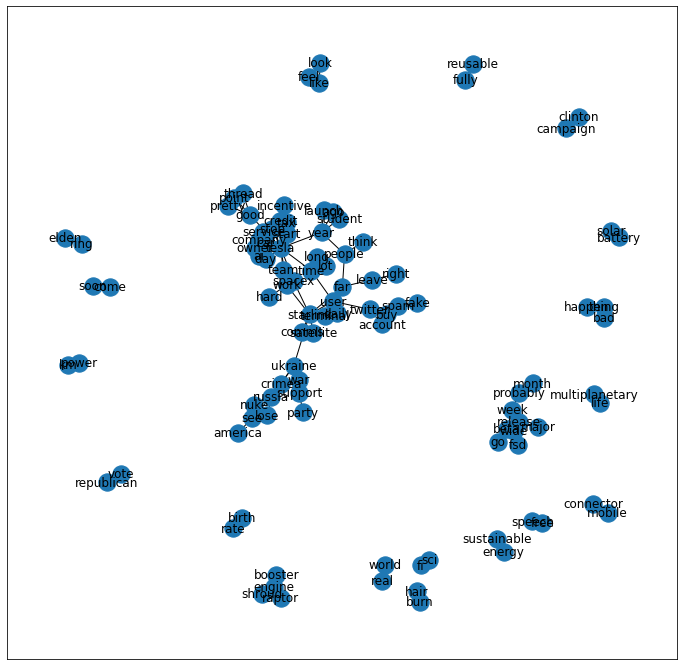

In [88]:
import networkx as nx

G = nx.from_pandas_edgelist(combDF, source="source", target="target")
plt.figure(figsize = (12,12))
nx.draw_networkx(G)   

The above graph is incredibly ugly. The interactive graph visualizer (gravis) can help create an interactive html network graph with more understandable parameters.

In [89]:
import gravis as gv
fig = gv.d3(G, edge_size_data_source='weight', use_edge_size_normalization=True, use_node_size_normalization=True, node_size_normalization_max=30,
             zoom_factor=0.6, use_x_positioning_force = True, x_positioning_force_strength = 0.05, use_y_positioning_force = True, y_positioning_force_strength = 0.05,
             use_centering_force = True, many_body_force_strength = -66)


Func = open("graphhtml.html","w", encoding = 'utf-8')
   
Func.write(fig.to_html())
              
Func.close()

i hate html i hate html i hate html i hate html i hate html i hate html i hate html i hate html i hate html i hate html

i hate html i hate html i hate html i hate html i hate html i hate html i hate html i hate html i hate html i hate html

To Do: Scatter plot of Sentiment vs subjectivity vs Pseudo-engagement (retweets + likes), in order to see which tweets garner the most amount of engagements with twitter users.

Engagement on Twitter is calculated as a sum of the Likes, Retweets, Quote Retweets, and Replies on any given tweet. We do not have the latter two of the those statistics, so our best statistic is calculating a "pseudoengagement" by summing up retweets and likes.

We will modify our original sentiment analyzer function in order to produce an absolute number for sentiment (calculated on a scale of -1 to + 1).

In [108]:
def sentiment_analyzer_num(tweetlist):
    
    analyser  = SentimentIntensityAnalyzer()
    sent = []
    tweetlist = list(tweetlist['Cleaned_Tweets'])
    for tweet in tweetlist:
        score = analyser.polarity_scores(tweet)
        sent.append(score['compound'])
    return sent

In [98]:
musktweets['pengagement'] = musktweets['Retweets'] + musktweets['Likes']
musktweets.head()

,Tweets,Retweets,Likes,Date,Cleaned_Tweets,pengagement
0,@PeterSchiff 🤣 thanks,209,7021,2022-10-27,thanks,7230
1,@ZubyMusic Absolutely,755,26737,2022-10-27,Absolutely,27492
2,Dear Twitter Advertisers https://t.co/GMwHmInPAS,55927,356623,2022-10-27,Dear Twitter Advertisers,412550
3,Meeting a lot of cool people at Twitter today!,9366,195546,2022-10-26,Meeting a lot of cool people at Twitter today!,204912
4,Entering Twitter HQ – let that sink in! https:...,145520,1043592,2022-10-26,Entering Twitter HQ – let that sink in!,1189112


In [100]:
musktweets.sort_values(by = 'pengagement', ascending = False).head()



,Tweets,Retweets,Likes,Date,Cleaned_Tweets,pengagement
1949,Next I’m buying Coca-Cola to put the cocaine b...,681707,4780787,2022-04-28,Next I’m buying Coca-Cola to put the cocaine b...,5462494
1969,I hope that even my worst critics remain on Tw...,368279,3232772,2022-04-25,I hope that even my worst critics remain on Tw...,3601051
1968,🚀💫♥️ Yesss!!! ♥️💫🚀 https://t.co/0T9HzUHuh6,348158,2608578,2022-04-25,Yesss!!!,2956736
1946,Let’s make Twitter maximum fun!,194742,2650644,2022-04-28,Let’s make Twitter maximum fun!,2845386
1945,"Listen, I can’t do miracles ok https://t.co/z7...",212854,2581112,2022-04-28,"Listen, I can’t do miracles ok",2793966


In [112]:
sentiment = sentiment_analyzer_num(musktweets)
musktweets['sentiment'] = sentiment

(array([  38.,   96.,  120.,  118., 1096.,  114.,  247.,  436.,  303.,
         100.]),
 array([-0.9509 , -0.75986, -0.56882, -0.37778, -0.18674,  0.0043 ,
         0.19534,  0.38638,  0.57742,  0.76846,  0.9595 ]),
 <BarContainer object of 10 artists>)

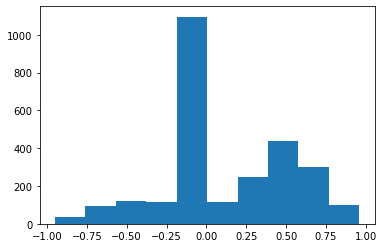

In [111]:
plt.hist(sentiment)

In [136]:
musktweets[musktweets.sentiment < -0.9].iloc[1].Cleaned_Tweets

'Obviously many disagree with this logic, but what do they think is their probability of being wrong about WW3. If they say 0%, they are utterly dangerous fools.'

In [143]:
musktweets[musktweets.sentiment > 0.9]

,Tweets,Retweets,Likes,Date,Cleaned_Tweets,pengagement,sentiment
33,"@ChananBos @SquawkCNBC @Kasparov63 Yeah, I’m b...",281,5838,2022-10-24,"Yeah, I’m back to spare bedroom /couch surfing...",6119,0.9001
57,@stillgray @DavidSacks Switzerland &amp; Belgi...,107,2003,2022-10-22,Switzerland &amp; Belgium have great chocolate...,2110,0.9239
441,@enn_nafnlaus @treygahigh @TaraBull808 @thelia...,81,1416,2022-09-21,Although his methods of instruction very stron...,1497,0.9074
567,@BLKMDL3 @Apple @SpaceX We’ve had some promisi...,860,9832,2022-09-08,We’ve had some promising conversations with Ap...,10692,0.9201
678,2 main goals this year: \n\n- Starship to orbi...,5808,75713,2022-08-22,2 main goals this year: - Starship to orbit- F...,81521,0.9595
1066,@TonyadeVitti @historydefined His success was ...,159,3085,2022-07-05,"His success was in fact due, in part, because ...",3244,0.9458
1185,@PPathole @teslaownersSV @TheTexanNews @MayraF...,1159,15823,2022-06-15,"I supported Yang last time, but DeSantis has a...",16982,0.9118
1364,It is rare for me to endorse political candida...,7675,98299,2022-06-03,It is rare for me to endorse political candida...,105974,0.9168
1399,@PinballReed @crikey_news @ummjackson @cameron...,632,7259,2022-05-31,My kids wrote better code when they were 12 th...,7891,0.9192
1705,"@intelligent_eat Yes, the purpose of AI Day is...",503,7835,2022-05-17,"Yes, the purpose of AI Day is to convince grea...",8338,0.9153


C:\Users\RICHAR~1\AppData\Local\Temp/ipykernel_468/2579445189.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['10\u00b2','10\u2076','10\u2075','10\u2074','10\u00b3','10\u00b2'])


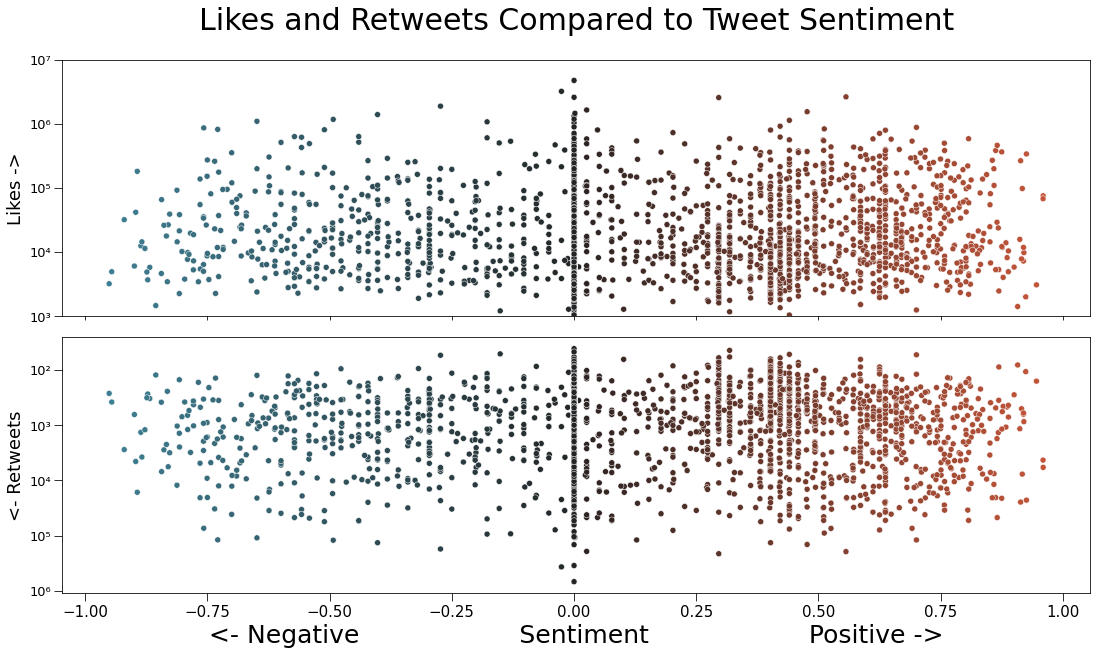

In [242]:


fig,(ax,ax2) = plt.subplots(2, 1, sharex=True, figsize = (15,8))
fig.tight_layout()

sns.scatterplot(data = musktweets, x = "sentiment", y = np.log10(musktweets.Likes), hue = "sentiment", 
    palette = sns.diverging_palette(220, 20, center = "dark", as_cmap=True), legend = False, ax = ax
)
sns.scatterplot(data = musktweets, x = "sentiment", y = -1*np.log10(musktweets.Retweets), hue = "sentiment", 
    palette = sns.diverging_palette(220, 20, center = "dark", as_cmap=True), legend = False, ax = ax2
)

ax.set_title("Likes and Retweets Compared to Tweet Sentiment", fontsize = 30,pad=30)
ax2.set_xlabel("<- Negative                    Sentiment                    Positive ->", fontsize = 25)
ax.set_ylim([3,7])
ax2.set_yticklabels(['10\u00b2','10\u2076','10\u2075','10\u2074','10\u00b3','10\u00b2'])
ax2.tick_params(axis = 'x', length = 8, labelsize = 15)
ax2.tick_params(axis = 'y', length = 8, labelsize = 13)
ax.set_yticks(ticks = [3.0,4.0,5.0,6.0,7.0])
ax.set_yticklabels(['10\u00b3','10\u2074','10\u2075','10\u2076','10\u2077'])
ax.tick_params(axis = 'y', length = 8, labelsize = 13)
ax.set_ylabel(ylabel = 'Likes ->',fontsize = 18)
ax2.set_ylabel(ylabel = '<- Retweets',fontsize = 18)
plt.savefig("lrtscatter.png", dpi = 400, bbox_inches = "tight")

In [158]:
del(ax)